Script for detecting the receptive field of task responding neurons
- First, we detect the neurons involved in the task computing the t-test between activity during different epochs vs fixation
- Second, from those neurons we compare the fr response against oposit positions (t-test to check significance)
- Third, compute indices for evaluating if visual, memory or motor neuron  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.analysis import raw_ch
from ephysvibe.task import task_constants,def_task
import os 

In [24]:
# load data
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-02-27_10-50-03_Riesling_lip_e1_r1.h5" #2023-02-27_10-50-03 2023-02-09_10-42-54
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

In [25]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 9


In [26]:
# Define target codes 
position_codes= {
    # code: [[MonkeyLogic axis], [plot axis]]
    '127': [[10,0],[1,2],[0]],
    '126': [[7,7],[0,2],[45]],
    '125': [[0,10],[0,1],[90]],
    '124': [[-7,7],[0,0],[135]],
    '123': [[-10,0],[1,0],[180]],
    '122': [[-7,-7],[2,0],[225]],
    '121': [[0,-10],[2,1],[270]],
    '120': [[7,-7],[2,2],[315]],
}
# create dict with the trials having each code
target_codes = {}
for i_key,key in enumerate(position_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1],'angle_codes':position_codes[key][2][0]}

In [27]:
np.where(data.code_numbers[trial_idx] == 'target_on')

/tmp/ipykernel_275584/1632417127.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.where(data.code_numbers[trial_idx] == 'target_on')


(array([], dtype=int64),)

In [28]:
event_align = task_constants.EVENTS_B2['target_on']
target_on = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx] == event_align)[1]]

event_align = task_constants.EVENTS_B2['target_off']
target_off = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx] == event_align)[1]]

event_align = task_constants.EVENTS_B2['fix_spot_off']
fix_spot_off = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx] == event_align)[1]]

event_align = task_constants.EVENTS_B2['eye_in_target']
eye_in_target = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx][:,:8] == event_align)[1]]

### Neurons responding to the task
check whether the neuron is responding to the task comparing each epoch with fixation 

In [29]:
fix_t = 200
dur_v = 250
st_m = 800
end_m = 1100

In [30]:
codes =  target_codes.keys()
all_e_aling = ['visual','delay','anticipation']

all_t_after = np.array([dur_v,750,end_m]) + fix_t
all_t_before = np.array([0,350,st_m]) + fix_t
n_spikes_sec = 5
t_test:Dict[str,list] = defaultdict(list)
i_good,i_mua, n_type = 0,0,0
for i_neuron,type_neuron in enumerate(data.clustersgroup):
    # check and count type of unit
    if type_neuron == 'good':
        i_good+=1
        n_type = i_good
    elif type_neuron == 'mua':
        i_mua+=1
        n_type = i_mua
    for t_before, t_after,e_align in zip(all_t_before,all_t_after,all_e_aling): # iterate by event
        # event_align = task_constants.EVENTS_B2[e_align]
        mean_sp=[]
        for code in codes: # iterate by code'
            target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus location
            trials_event_time = data.code_samples[ target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
            shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-fix_t).astype(int), axis=1) # align trials with (target_on - fix_t)
            # select trials with at least one spike
            shift_sp = shift_sp[np.nansum(shift_sp,axis=1)>0]
            # mean fr during event
            mean_sp = shift_sp[:, t_before:t_after].mean(axis=0) # Average fr of all trials 
            # mean fr during fixation
            mean_sp_fix = shift_sp[:, :fix_t].mean(axis=0)# Average fr of all trials 
            # check number of spikes, at least 5/sec 
            # shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-fix_t).astype(int), axis=1)[:, :end_m]
            if np.any(np.sum(shift_sp[:, fix_t:end_m+fix_t],axis=1)>=n_spikes_sec * (end_m/1000)): # if at least n_spikes_sec, compute and save t-test in pd.DataFrame
                p=stats.ttest_ind(mean_sp, mean_sp_fix)[1]
                t_test['code']+=[code]
                t_test['cluster']+=[n_type]
                t_test['group']+=[type_neuron]
                t_test['array_position']+=[i_neuron]
                t_test['event']+=[e_align]
                t_test['p']+=[p]
t_test_sacc = pd.DataFrame(t_test)

/tmp/ipykernel_275584/3789551119.py:27: RuntimeWarning: Mean of empty slice.
  mean_sp = shift_sp[:, t_before:t_after].mean(axis=0) # Average fr of all trials
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_275584/3789551119.py:29: RuntimeWarning: Mean of empty slice.
  mean_sp_fix = shift_sp[:, :fix_t].mean(axis=0)# Average fr of all trials


In [31]:
p_threshold = 0.05
below_threshold = t_test_sacc[t_test_sacc['p']<p_threshold] # results below threshold
significant_units = below_threshold['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)

below_threshold

Units showing significant activity: [0 2 3 4 5 6]


,code,cluster,group,array_position,event,p
0,120,1,mua,0,visual,8.114750e-03
1,120,1,mua,0,delay,1.399742e-12
2,120,1,mua,0,anticipation,2.135670e-10
4,126,1,good,2,visual,2.221706e-10
5,125,1,good,2,visual,3.099615e-11
13,125,1,good,2,delay,4.159692e-02
15,123,1,good,2,delay,4.339204e-03
23,123,1,good,2,anticipation,2.468072e-02
28,126,3,mua,3,visual,8.966688e-05
29,125,3,mua,3,visual,3.731563e-05


### Neurons RF
Check if signif compared to opposite location

In [32]:

left = np.array(['125','124','123','122'])
right = np.array(['121','120','127','126'])
sacc_index = []
rf_t_test:Dict[str,list] = defaultdict(list)


for i_neuron in significant_units:
    i_neuron_df = below_threshold[below_threshold['array_position']==i_neuron]

    i_neuron_codes = i_neuron_df['code'].values
    i_neuron_events = i_neuron_df['event'].values
    for i_code, i_event in zip(i_neuron_codes,i_neuron_events):
        if i_code in left:
            idx = np.where(left == i_code)[0]
            opposite_code = right[idx][0]
        else:
            idx = np.where(right == i_code)[0]
            opposite_code = left[idx][0]

        # i_code
        target_t_idx = target_codes[i_code]["trial_idx"] # select trials with the same stimulus
        trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial        
        shift_sp_r = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time).astype(int), axis=1) # align trials with event onset
        # opposite_code
        target_t_idx = target_codes[opposite_code]["trial_idx"] # select trials with the same stimulus
        trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
        shift_sp_l = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time).astype(int), axis=1)# align trials with event onset
        
        if i_event == 'visual': # visuel 

            # Code: select trials with at least one spike
            shift_sp_r = shift_sp_r[np.nansum(shift_sp_r,axis=1)>0][:, :dur_v]
            mean_sp_code = shift_sp_r.mean(axis=0) # Average fr of all trials  
            # opposite_code: select trials with at least one spike
            shift_sp_l = shift_sp_l[np.nansum(shift_sp_l,axis=1)>0][:, :dur_v] 
            mean_sp_opposite = shift_sp_l.mean(axis=0) # Average fr of all trials  

        elif i_event == 'anticipation': # motor 
            # Code: select trials with at least one spike
            shift_sp_r = shift_sp_r[np.nansum(shift_sp_r,axis=1)>0][:, st_m:end_m] 
            mean_sp_code = shift_sp_r.mean(axis=0) # Average fr of all trials  
            # opposite_code: select trials with at least one spike
            shift_sp_l = shift_sp_l[np.nansum(shift_sp_l,axis=1)>0][:, st_m:end_m]  
            mean_sp_opposite = shift_sp_l.mean(axis=0) # Average fr of all trials  
                        
        else:# i_vm_idx <= -vm_threshold: # visuomotor 
            # Code: select trials with at least one spike
            shift_sp_r = shift_sp_r[np.nansum(shift_sp_r,axis=1)>0][:, :1100] 
            mean_sp_code = shift_sp_r.mean(axis=0) # Average fr of all trials  
            # opposite_code: select trials with at least one spike
            shift_sp_l = shift_sp_l[np.nansum(shift_sp_l,axis=1)>0][:, :1100]  
            mean_sp_opposite = shift_sp_l.mean(axis=0) # Average fr of all trials  

        # check there is at least 1 trial
        p = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]
        larger = mean_sp_code.mean()>mean_sp_opposite.mean()
        rf_t_test['code']+=[i_code]
        rf_t_test['array_position']+=[i_neuron]
        rf_t_test['p']+=[p ]  
        rf_t_test['larger']+=[larger ]  
        rf_t_test['type']+=[i_event]  
 
    
rf_t_test = pd.DataFrame(rf_t_test)

In [33]:
p_threshold = 0.05
rf_t_test_threshold = rf_t_test[np.logical_and(rf_t_test['p']<p_threshold,rf_t_test['larger']==True)] # results below threshold
significant_units = rf_t_test_threshold['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)

rf_t_test_threshold

Units showing significant activity: [0 2 3 4 5 6]


,code,array_position,p,larger,type
0,120,0,9.444990e-06,True,visual
1,120,0,4.278230e-05,True,delay
3,126,2,2.791318e-05,True,visual
4,125,2,8.514219e-05,True,visual
8,126,3,4.420994e-02,True,visual
14,127,4,4.603312e-03,True,visual
15,126,4,1.105630e-05,True,visual
16,125,4,7.316396e-03,True,visual
17,126,4,4.838593e-10,True,delay
18,125,4,5.478367e-07,True,delay


### Visuomotor index
check whether a neuron is visual, motor or visuomotor comparing the activity during sample presentation vs motor preparation

In [34]:

vm_index_df:Dict[str,list] = defaultdict(list)
for i_neuron in significant_units:
    codes_sig = rf_t_test_threshold[rf_t_test_threshold['array_position']==i_neuron]['code'].unique()

    for i_code in codes_sig:
        target_t_idx = target_codes[i_code]["trial_idx"] # select trials with the same stimulus
        # select trials
        trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
        shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-fix_t).astype(int), axis=1) # align trials with event onset
        shift_sp = shift_sp[np.nansum(shift_sp,axis=1)>0]# select trials with at least one spike
        # visual response
        shift_sp_visual = shift_sp[:, fix_t:fix_t+dur_v]
        mean_sp_visual = shift_sp_visual.mean(axis=0) # Average fr of all trials  
        # motor response 
        shift_sp_motor = shift_sp[:, fix_t+st_m:fix_t+end_m]
        mean_sp_motor = shift_sp_motor.mean(axis=0) # Average fr of all trials  
        # fix response
        mean_sp_fix = shift_sp[:, :fix_t].mean()
        # compute p value
        p= stats.ttest_ind(mean_sp_visual, mean_sp_motor)[1]
        # compute index
        m_mean = np.abs(shift_sp_motor.mean() - mean_sp_fix)
        v_mean = np.abs(shift_sp_visual.mean() - mean_sp_fix)
        vm_index = (m_mean-v_mean)/(v_mean+m_mean)
        # save results
        vm_index_df['code']+=[i_code]
        vm_index_df['array_position']+=[i_neuron]
        vm_index_df['p']+=[p ]    
        vm_index_df['vm_index']+=[vm_index]  
vm_index_df = pd.DataFrame(vm_index_df)

In [35]:
idx_plot = np.around(vm_index_df[vm_index_df['p']<0.05]['vm_index'].values,1)

In [36]:
data.clustersgroup

array(['mua', 'mua', 'good', 'mua', 'good', 'mua', 'mua', 'mua', 'good'],
      dtype='<U4')

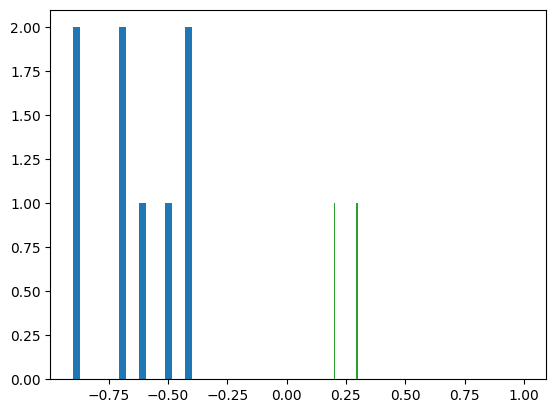

In [37]:
vm_threshold = 0.4
plt.hist(idx_plot[idx_plot<=-vm_threshold],bins=18)
plt.hist(idx_plot[idx_plot>=vm_threshold],bins=18)
a=plt.hist(idx_plot[np.logical_and(idx_plot>-vm_threshold,idx_plot<vm_threshold)],bins=18)

In [38]:
vm_index_df_sig = vm_index_df[vm_index_df['p']<0.05]
vm_index_df_sig

,code,array_position,p,vm_index
0,120,0,1.286303e-04,0.288660
1,126,2,1.195674e-09,-0.734375
2,125,2,3.216939e-09,-0.659292
3,126,3,1.066330e-06,-0.850746
4,127,4,1.990085e-02,-0.621212
5,126,4,4.655115e-04,-0.397394
7,127,5,6.066634e-04,-0.454545
9,125,5,1.559555e-02,0.154485
10,124,5,2.399187e-02,-0.444444
11,126,6,4.175120e-05,-0.897959


compare activity in one location with the opposite location during the same periode (visual/motor)

In [39]:
data.clustersgroup

array(['mua', 'mua', 'good', 'mua', 'good', 'mua', 'mua', 'mua', 'good'],
      dtype='<U4')

### Plot

/home/INT/losada.c/Documents/codes/EphysVibe/ephysvibe/trials/spikes/plot_raster.py:42: RuntimeWarning: Mean of empty slice.
  mean_sp = shift_sp.mean(axis=0)  # mean of all trials
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_275584/3145668954.py:36: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, all_max_conv + max_num_trials * 3)
/tmp/ipykernel_275584/3145668954.py:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(-all_max_conv, max_num_trials)


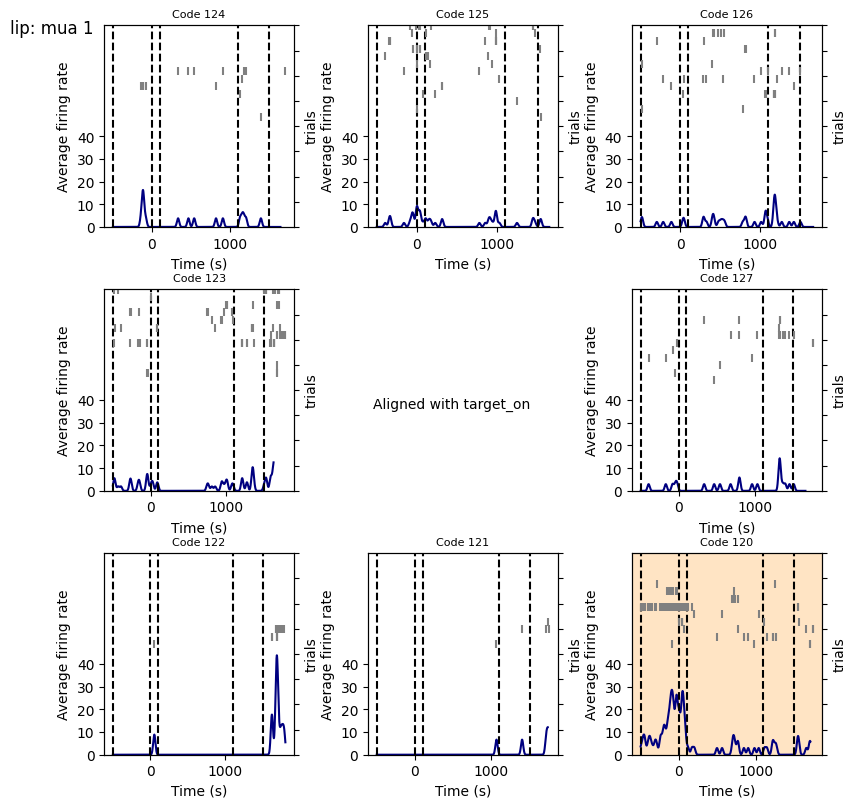

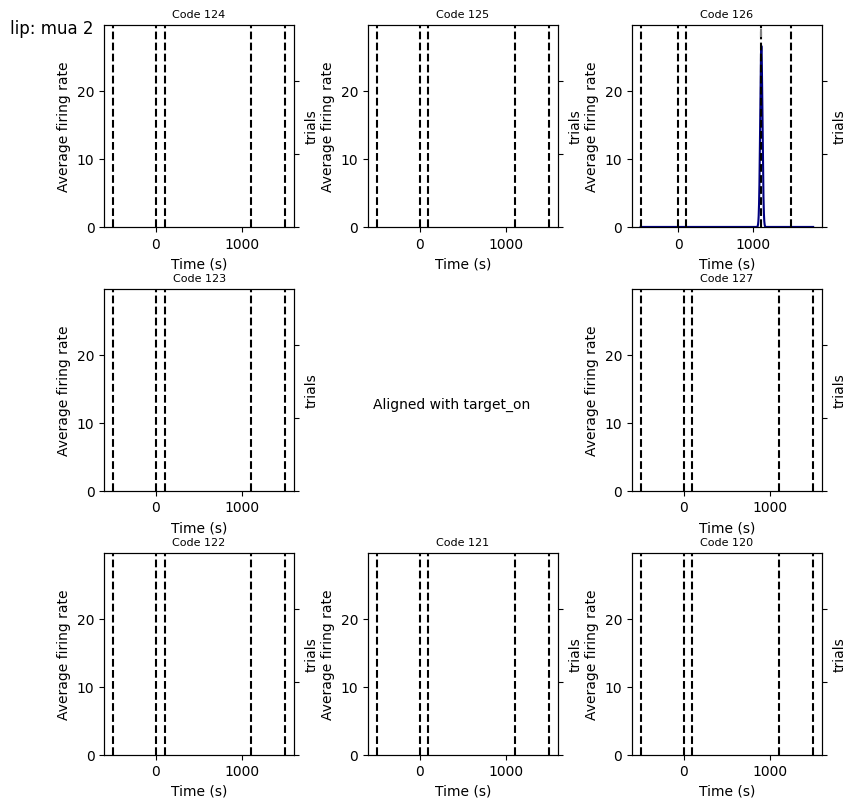

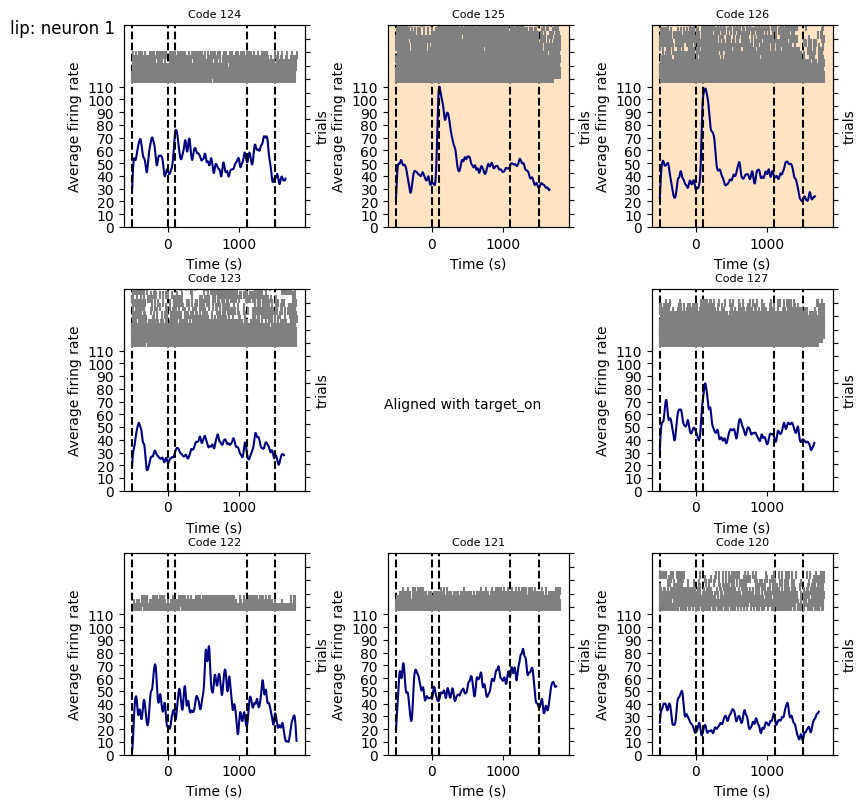

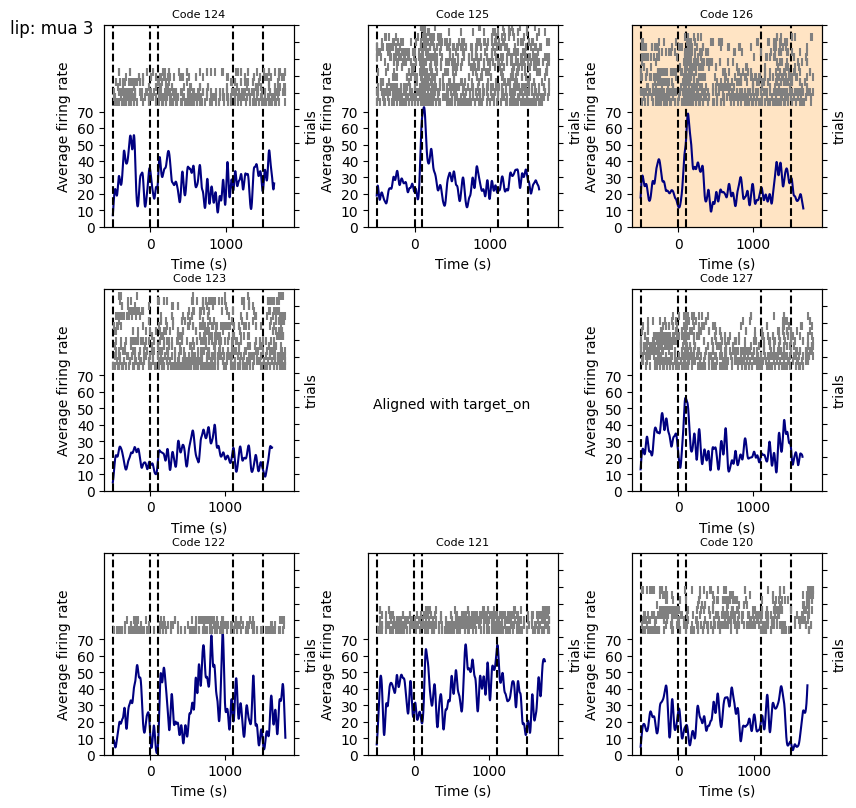

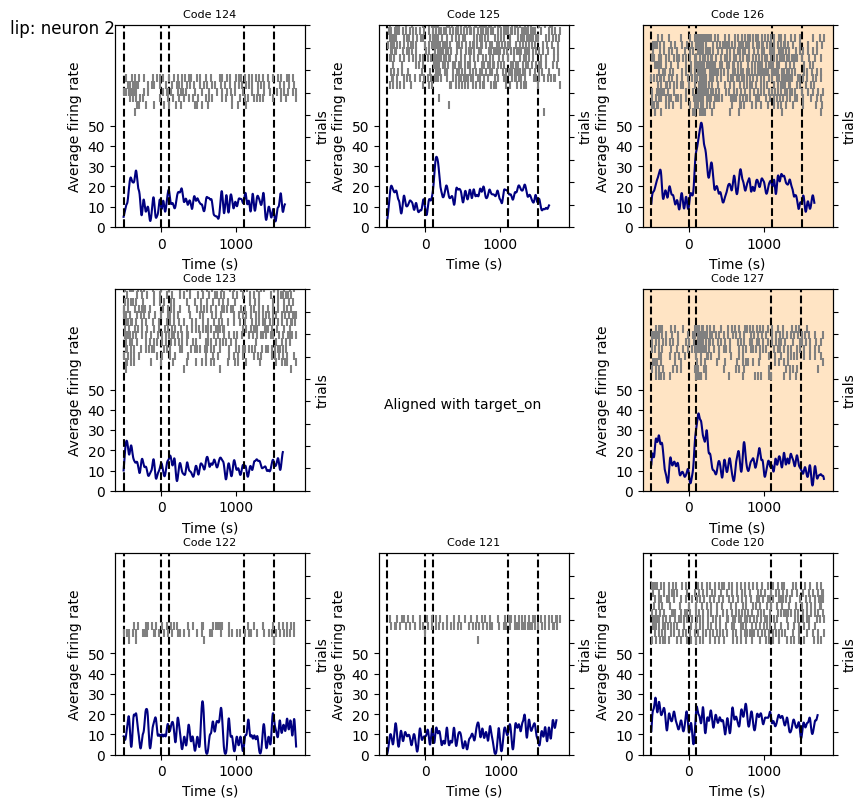

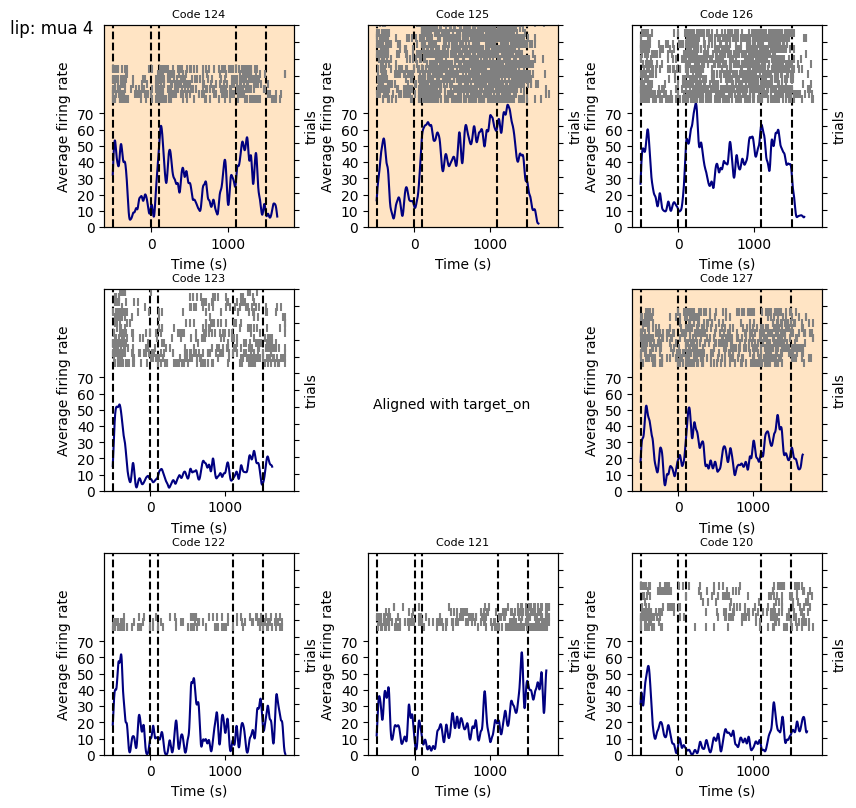

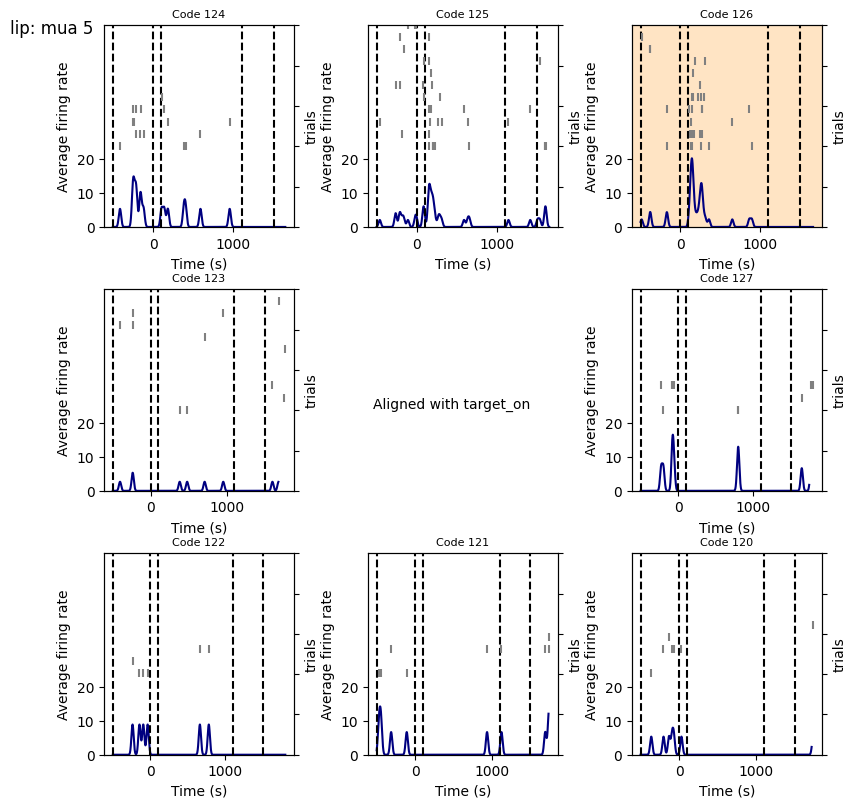

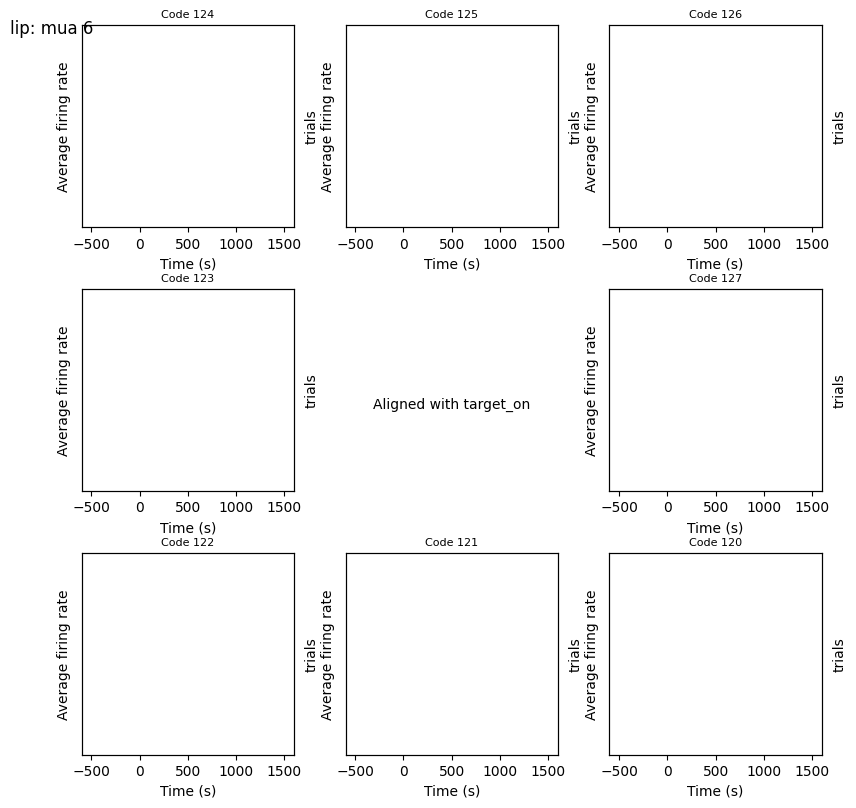

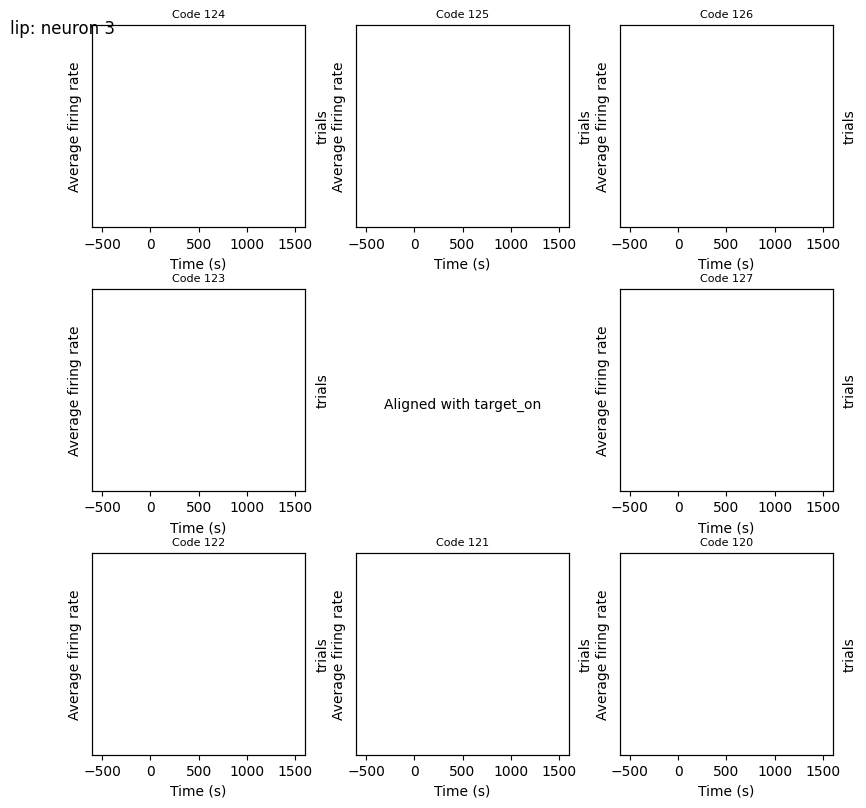

In [40]:
# kernel parameters
t_before=500
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
e_align='target_on'
# select only individual neurons
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup): # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1

    code_samples=data.code_samples
    code_numbers=data.code_numbers
    sp_samples=data.sp_samples
    e_code_align = task_constants.EVENTS_B2[e_align]
    fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) # define figure
    all_ax, all_ax2,all_max_conv,max_num_trials=plot_raster.plot_activity_location(target_codes,code_samples,code_numbers,sp_samples, i_n, e_code_align, t_before,fs_ds, kernel,vm_index_df_sig)
    avg_events = [-500, 0, 100,1100,1500]
    num_trials = shift_sp.shape[0]
    for ax, ax2 in zip(all_ax, all_ax2):
        for ev in avg_events:
            ax.vlines(
                ev,
                0,
                all_max_conv + max_num_trials * 3,
                color="k",
                linestyles="dashed",
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials * 3)
        ax.set_yticks(np.arange(0, all_max_conv, 10))
        ax2.set_ylim(-all_max_conv, max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv, max_num_trials * 3, 10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)

    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    fig.suptitle("%s: %s %d" % (s_path[-2], cluster, i_cluster), x=0)
    fig.text(
        0.5,
        0.5,
        s="Aligned with %s" % e_align,
        horizontalalignment="center",
        verticalalignment="center",
    )

# Plot circular max fr/localion

In [22]:
color={'visual':'b','motor':'g'}

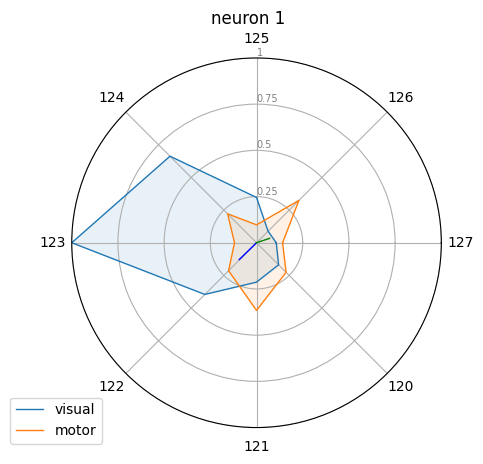

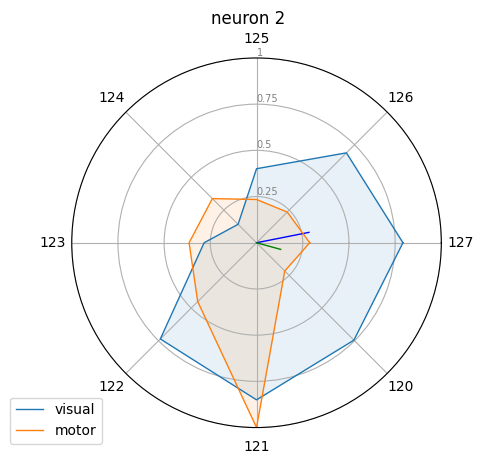

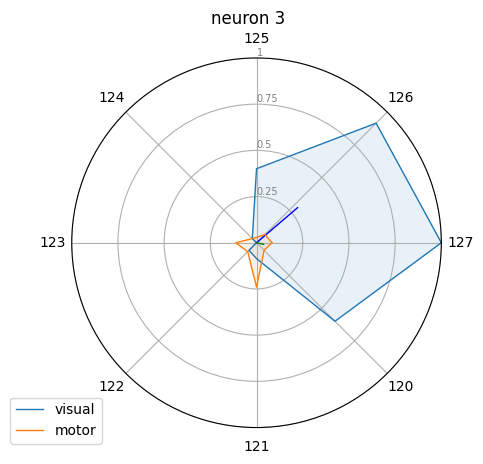

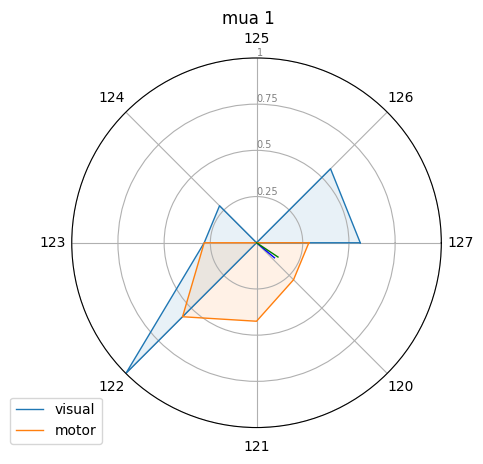

In [23]:
t_before=500
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
win_size = int(sp_constants.W_SIZE * fs_ds)
e_align='target_on'
# select only individual neurons
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup): # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1

    code_samples=data.code_samples
    code_numbers=data.code_numbers
    sp_samples=data.sp_samples
    e_code_align = task_constants.EVENTS_B2[e_align]
    #fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) # define figure
    fr_max_visual,fr_max_motor,fr_angle,fr_max_trial=[],[],[],[]
    
    for code in target_codes.keys():
        target_t_idx = target_codes[code][
            "trial_idx"
        ]  # select trials with the same stimulus
        trials_s_on = code_samples[target_t_idx,np.where(code_numbers[target_t_idx] == e_code_align)[1]]  
        shift_sp = TrialsData.indep_roll(sp_samples[target_t_idx, i_n],-(trials_s_on-win_size).astype(int),axis=1)  # align trials on event
        # select trials with at least one spike

        shift_sp = shift_sp[np.nansum(shift_sp, axis=1) > 0]
        mean_sp = shift_sp.mean(axis=0)  # mean of all trials
        conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        fr_max_visual.append(max(conv[win_size:win_size+dur_v]))

        fr_angle.append(target_codes[code]['angle_codes'])
       
        
        fr_max_motor.append(max(conv[ win_size+800:win_size+1100]))
        fr_max_trial.append(max(conv[win_size:win_size+1100]))
    fr_max_trial = max(fr_max_trial)
    fig,ax = plt.subplots(subplot_kw={'projection':'polar'} )
    fr_angle_rad=((np.array(fr_angle)*2 * np.pi )/360).tolist()
    fr_angle_rad += fr_angle_rad[:1]
    for fr_max,event in zip([fr_max_visual, fr_max_motor],['visual','motor']):
        norm_fr_max = (np.array(fr_max)/fr_max_trial).tolist()
        norm_fr_max += norm_fr_max[:1]
        ax.set_rlabel_position(90)
        plt.yticks([0.25,0.5,0.75,1], ['0.25','0.5','0.75','1'], color="grey", size=7)
        plt.ylim(0,1)
        plt.xticks(fr_angle_rad[:-1], target_codes.keys())
        
        ax.plot(fr_angle_rad, norm_fr_max, linewidth=1, linestyle='solid', label=event)
        ax.fill(fr_angle_rad, norm_fr_max, alpha=0.1)
        # plot resultant
        r_vector = np.mean(np.array(norm_fr_max[:-1])*np.cos(np.array(fr_angle_rad[:-1])*180/np.pi))
        im_vector = np.mean(np.array(norm_fr_max[:-1])*np.sin(np.array(fr_angle_rad[:-1])*180/np.pi))
        
        ang = np.angle([r_vector+ 1j *(im_vector)])[0]
        if ang < 0:
            ang=ang+2*np.pi
        rad = np.abs([r_vector+ 1j *(im_vector)])[0]
        ax.plot([0,ang], [0,rad], linewidth=1, linestyle='solid', color=color[event])

        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    fig.suptitle("%s %d"%(cluster,i_cluster))





In [ ]:
r_vector = np.mean(np.array(norm_fr_max[:-1])*np.cos(fr_angle_rad[:-1]))
im_vector = np.mean(np.array(norm_fr_max[:-1])*np.sin(fr_angle_rad[:-1]))
np.angle([r_vector+ 1j *(im_vector)])
np.abs([r_vector+ 1j *(im_vector)])

array([0.09711547])